In [142]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import torch
import cvxpylayers
from cvxpylayers.torch import CvxpyLayer
from tqdm import trange, tqdm
from time import sleep
from algorithms import fit
from utils import latexify

torch.set_default_dtype(torch.float32)
torch.manual_seed(0)
latexify()

In [2]:
# if torch.cuda.is_available():  
#     print('cuda available')
#     dev = "cuda:0" 
# else:  
#     dev = "cpu"  
# device = torch.device(dev)

# helper functions

In [217]:
def plot_results(val_losses, train_losses, param_updates, obj_vals, sqrtalpha_true, beta_true, P_untrained, P_trained, P_true, dist):
    epochs = len(val_losses)
    
    # loss by epoch
    plt.figure(figsize=(6,4))
    plt.plot(val_losses, 'k', label='val')
    plt.plot([np.mean(tl) for tl in train_losses], 'k--', label='train')
    plt.xlabel('epoch')
    plt.ylabel('loss')
#     plt.title('Validation and training loss by epoch')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figures/grid2/loss_%s.pdf'%dist)

    # alpha updates by epoch
    plt.figure(figsize=(6,4))
    plt.plot(param_updates[:,0].detach().numpy(), 'k', label='$\sqrt{\\alpha}$')
    plt.hlines(sqrtalpha_true, 0, epochs, colors='k', linestyles='dashed', label='$\sqrt{\\alpha^\mathrm{true}}$')
    plt.xlabel('epoch')
    plt.ylabel('$\sqrt{\\alpha}$')
#     plt.title('$\sqrt{\\alpha}$ updates by epoch')
    plt.legend()
    plt.savefig('figures/grid2/sqrtalpha_%s.pdf'%dist)

    # generator objective value by epoch
    plt.figure(figsize=(6,4))
    plt.plot(obj_vals, 'k', label='train')
    plt.hlines(f_gen(P_true[0,:,0], sqrtalpha_true, beta_true).value, 0, epochs-1, colors='k', linestyles='dashed', label='true')
#     plt.title('Generator local cost function by epoch')
    plt.xlabel('epoch')
    plt.ylabel('cost')
    plt.legend()
    plt.savefig('figures/grid2/objval_%s.pdf'%dist)

    # balance over time
    plt.figure(figsize=(6,4))
    plt.plot(np.sum(P_untrained.detach().numpy(), axis=1), linestyle='dotted', label='untrained')
    plt.plot(np.sum(P_trained.detach().numpy(), axis=1), label='trained')
    plt.plot(torch.sum(P_true[0,:,:], axis=1), '--', label='true')
#     plt.title('Balance over time')
    plt.xlabel('$t$')
    plt.ylabel('balance')
    lower,upper = -7e-7,7e-7
    if dist=='d':
        lower,upper = -2e-6,2e-6 
    plt.ylim((lower,upper))
    plt.legend()
    plt.savefig('figures/grid2/balance_%s.pdf'%dist)

# setup

In [141]:
T = 20
M = 3
#0.01,50,50,10,10
pmin, pmax = 0, 10
Q, C, D = 5,1,1

In [54]:
# generator that can't be powered off (for simplicity and convexity)
def f_gen(p_gen,sqrt_alpha,beta):
    return cp.sum_squares(sqrt_alpha*p_gen) - beta*cp.sum(p_gen)

def c_gen(p_gen):
    constraints = [-p_gen >= pmin,
                   -p_gen <= pmax
                  ]
    return constraints

In [55]:
# load (fixed)
def f_load(p_load):
    return 0

def c_load(p_load,l):
    constraints = [p_load == l]
    return constraints

In [56]:
# storage device
def f_bat(p_bat):
    return 0

def c_bat(p_bat):
    q = cp.cumsum(p_bat)
    constraints = [p_bat >= -D,
                   p_bat <= C,
                   q >= 0,
                   q <= Q,
                  ]
    return constraints

# method 1: centralized

In [143]:
# set up variables and parameters
sqrt_alpha = cp.Parameter()
beta = cp.Parameter()
l = cp.Parameter(T)
p = cp.Variable((T,M))
    
# set up objective
objective = f_gen(p[:,0],sqrt_alpha,beta)
constraints = [c for c in c_gen(p[:,0])] + [c for c in c_load(p[:,1],l)] + [c for c in c_bat(p[:,2])] + [cp.sum(p,axis=1)==0]
prob = cp.Problem(cp.Minimize(objective),constraints)

# convert into pytorch layer
layer = CvxpyLayer(prob, [sqrt_alpha,beta,l], [p])

## forward pass

In [144]:
# get data
def get_data_nd(N, T, sqrtalpha, beta):
    L = torch.randint(3,10,size=(N,T))
    L = L.float()
    sqrtalpha = sqrtalpha.repeat(N)
    beta = beta.repeat(N)
    P = layer(sqrtalpha,beta,L,solver_args={"solve_method":'ECOS'})[0]

    return L,P

alphamin = 0.1
alphamax = 0.2
alpha_true = (alphamax-alphamin)*torch.rand(1) + alphamin
sqrtalpha_true = torch.sqrt(alpha_true)
print('sqrtalpha_true: ', sqrtalpha_true)

betamin = 0.5
betamax = 1
beta_true = (betamax-betamin)*torch.rand(1) + betamin
print('beta_true: ', beta_true)

L, P_nd = get_data_nd(100, T, sqrtalpha_true, beta_true)
Lval, Pval_nd = get_data_nd(50, T, sqrtalpha_true, beta_true)

sqrtalpha_true:  tensor([0.3868])
beta_true:  tensor([0.8841])


## backward pass

In [154]:
l1_loss = torch.nn.L1Loss()
torch.manual_seed(0)
sqrtalpha = 3*torch.rand(1)
print(sqrtalpha)
beta = beta_true
sqrtalpha.requires_grad_(True)

def loss_nd(L,P,sqrtalpha,beta):
    N = L.shape[0]
    sqrtalpha_batch = sqrtalpha.repeat(N)
    beta_batch = beta.repeat(N)
    return l1_loss(layer(sqrtalpha_batch, beta_batch, L, solver_args={"solve_method":'ECOS'})[0],P)

tensor([1.4888])


In [155]:
epochs = 30
val_losses_nd, train_losses_nd, param_updates_nd = fit(lambda L,P: loss_nd(L,P,sqrtalpha,beta), [sqrtalpha], L, P_nd, Lval, Pval_nd,
                                                       opt=torch.optim.Adam, opt_kwargs={"lr": 5e-2},
                                                       batch_size=20, epochs=epochs, verbose=True)

001 | 0.00014
batch 001 / 005 | 0.00014
batch 002 / 005 | 0.00014
batch 003 / 005 | 0.00013
batch 004 / 005 | 0.00013
batch 005 / 005 | 0.00013
002 | 0.00013
batch 001 / 005 | 0.00013
batch 002 / 005 | 0.00012
batch 003 / 005 | 0.00012
batch 004 / 005 | 0.00011
batch 005 / 005 | 0.00011
003 | 0.00011
batch 001 / 005 | 0.00009
batch 002 / 005 | 0.00010
batch 003 / 005 | 0.00010
batch 004 / 005 | 0.00010
batch 005 / 005 | 0.00009
004 | 0.00009
batch 001 / 005 | 0.00008
batch 002 / 005 | 0.00007
batch 003 / 005 | 0.00008
batch 004 / 005 | 0.00009
batch 005 / 005 | 0.00009
005 | 0.00008
batch 001 / 005 | 0.00008
batch 002 / 005 | 0.00007
batch 003 / 005 | 0.00007
batch 004 / 005 | 0.00006
batch 005 / 005 | 0.00005
006 | 0.00003
batch 001 / 005 | 0.00005
batch 002 / 005 | 0.00004
batch 003 / 005 | 0.00003
batch 004 / 005 | 0.00004
batch 005 / 005 | 0.00004
007 | 0.00004
batch 001 / 005 | 0.00007
batch 002 / 005 | 0.00007
batch 003 / 005 | 0.00006
batch 004 / 005 | 0.00005
batch 005 / 005 | 

In [156]:
N = Lval.shape[0]
obj_vals_nd = np.zeros(epochs)
for epoch in range(epochs):
    sqrtalpha_temp = param_updates_nd[epoch,0]
    P_gen_temp = layer(sqrtalpha_temp, beta_true, Lval[0,:], solver_args={"solve_method":'ECOS'})[0][0,:,0]
    obj_vals_nd[epoch] = f_gen(P_gen_temp.detach().numpy(), sqrtalpha_temp.detach().numpy(), beta_true).value
    
P_untrained_nd = layer(param_updates_nd[0,0], beta_true, Lval[0,:], solver_args={"solve_method":'ECOS'})[0][0,:,:]
P_trained_nd = layer(param_updates_nd[-1,0], beta_true, Lval[0,:], solver_args={"solve_method":'ECOS'})[0][0,:,:]

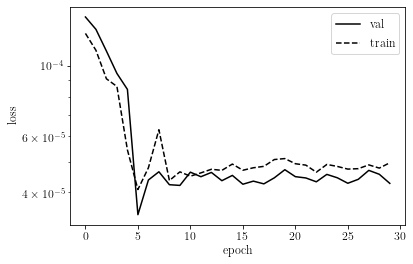

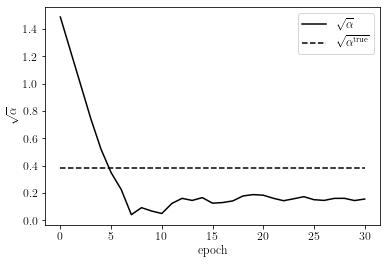

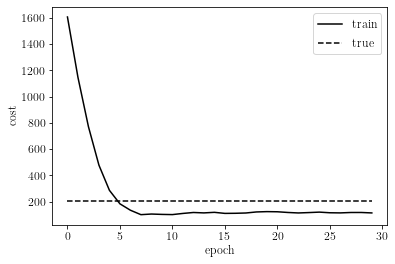

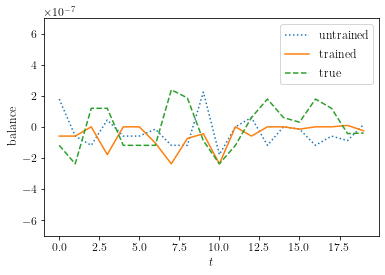

In [218]:
plot_results(val_losses_nd, train_losses_nd, param_updates_nd, obj_vals_nd, sqrtalpha_true, beta_true, P_untrained_nd, P_trained_nd, Pval_nd, 'nd')

In [226]:
# results
print('final sqrt(alpha) estimate: ', param_updates_nd[-1,:].detach().numpy()[0])
print('true sqrt(alpha): ', sqrtalpha_true.detach().numpy()[0])
print('final objval estimate: ', obj_vals_nd[-1])
print('true objval: ', f_gen(Pval_nd[0,:,0], sqrtalpha_true, beta_true).value[0])

final sqrt(alpha) estimate:  0.15679824
true sqrt(alpha):  0.38681477
final objval estimate:  115.23710545778425
true objval:  202.40317754321705


# method 2: distributed

In [162]:
QUIET    = 1
MAX_ITER = 100
rho = 1

In [171]:
pvar = [cp.Variable(T)]*2
d = cp.Parameter(T)
v = cp.Parameter(T)
sqrt_alpha = cp.Parameter()
beta = cp.Parameter()
obj = [f_gen(pvar[0],sqrt_alpha,beta) + rho/2*cp.sum_squares(v - pvar[0]),
       rho/2*cp.sum_squares(v - pvar[1])]
prox = [cp.Problem(cp.Minimize(obj[0]), c_gen(pvar[0])),
        cp.Problem(cp.Minimize(obj[1]), c_bat(pvar[1]))]
layers = [CvxpyLayer(prox[0],[v,sqrt_alpha,beta],[pvar[0]]),
          CvxpyLayer(prox[1],[v],[pvar[1]])]

In [180]:
def admm(L,sqrtalpha,beta,layers):
    N,T = L.shape
    
    P = torch.zeros((N,T,M))
    P[:,:,1] = L
    u = torch.zeros((N,T,M))
    r_norm = torch.zeros((N,MAX_ITER))
    s_norm = torch.zeros((N,MAX_ITER))

    for k in tqdm(range(MAX_ITER)):
        P_old = P
        Pbar_old = torch.mean(P_old,axis=2,keepdim=True)
        
        # p-update
        try:
            P[:,:,0] = layers[0](P[:,:,0] - torch.mean(P,axis=2) - u[:,:,0],sqrtalpha,beta,solver_args={'solve_method': 'ECOS'})[0]   # generator
        except:
            break
        try:
            P[:,:,2] = layers[1](P[:,:,2] - torch.mean(P,axis=2) - u[:,:,2],solver_args={'solve_method': 'ECOS'})[0]                  # battery 
        except:
            break
        
        Pbar = torch.mean(P,axis=2,keepdim=True)

        # u-update
        u += Pbar
        
        # progress tracking
        r_norm[:,k] = torch.flatten(torch.linalg.norm(Pbar,dim=1))
        s_norm[:,k] = torch.flatten(torch.linalg.norm(torch.reshape((P - Pbar) - (P_old - Pbar_old),(N,T*M)),dim=1))
        
    return P,r_norm,s_norm

## forward pass

In [173]:
def get_data_d(L, sqrtalpha, beta):
    N = L.shape[0]
    P,r_norm,s_norm = admm(L, sqrtalpha.repeat(N), beta.repeat(N), layers)

    return P,r_norm,s_norm

P_d, r_norm, s_norm = get_data_d(L, sqrtalpha_true, beta_true)
Pval_d, r_normval, s_normval = get_data_d(Lval, sqrtalpha_true, beta_true)

100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


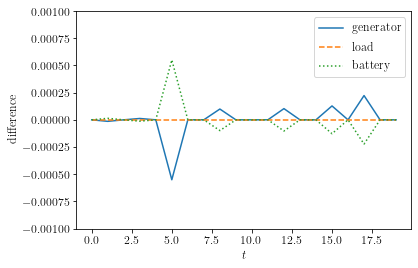

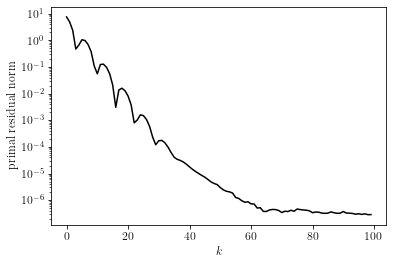

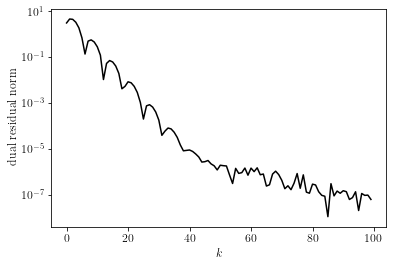

In [199]:
# compare results for each device
plt.figure(figsize=(6,4))
plt.plot(P_d[0,:,0] - P_nd[0,:,0], label='generator')
plt.plot(P_d[0,:,1] - P_nd[0,:,1], '--', label='load')
plt.plot(P_d[0,:,2] - P_nd[0,:,2], linestyle='dotted', label='battery')
# plt.title('Difference between $p$ values calculated using ADMM and centralized methods')
plt.xlabel('$t$')
plt.ylabel('difference')
plt.legend()
plt.ylim((-1e-3,1e-3))
plt.savefig('figures/grid2/fp_comp.pdf')

# primal residual tracking 
plt.figure(figsize=(6,4))
plt.plot(r_normval[0,:], 'k')
plt.yscale('log')
# plt.title('Primal residual norms by iteration')
plt.xlabel('$k$')
plt.ylabel('primal residual norm')
plt.savefig('figures/grid2/fp_rnorm.pdf')

# dual residual tracking
plt.figure(figsize=(6,4))
plt.plot(s_normval[0,:], 'k')
plt.yscale('log')
# plt.title('Dual residual norms by iteration')
plt.xlabel('$k$')
plt.ylabel('dual residual norm')
plt.savefig('figures/grid2/fp_snorm.pdf')

# backward pass

In [190]:
l1_loss = torch.nn.L1Loss()
torch.manual_seed(0)
sqrtalpha = 3*torch.rand(1)
print(sqrtalpha)
beta = beta_true
sqrtalpha.requires_grad_(True)

def loss_d(L,P,sqrtalpha,beta):
    N = L.shape[0]
    return l1_loss(admm(L, sqrtalpha.repeat(N), beta.repeat(N), layers)[0],P)

tensor([1.4888])


In [191]:
val_losses_d, train_losses_d ,param_updates_d = fit(lambda L,P: loss_d(L,P,sqrtalpha,beta), [sqrtalpha], L, P_d, Lval, Pval_d,
                                                    opt=torch.optim.Adam, opt_kwargs={"lr": 5e-2},
                                                    batch_size=20, epochs=epochs, verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.
001 | 1.45362


  4%|▍         | 4/100 [00:02<00:49,  1.93it/s]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.



  0%|          | 0/100 [00:00<?, ?it/s]

batch 001 / 005 | 1.46982


  6%|▌         | 6/100 [00:02<00:42,  2.21it/s]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.



  0%|          | 0/100 [00:00<?, ?it/s]

batch 002 / 005 | 1.33621


  5%|▌         | 5/100 [00:05<01:41,  1.07s/it]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.



  0%|          | 0/100 [00:00<?, ?it/s]

batch 003 / 005 | 1.32442


  5%|▌         | 5/100 [00:01<00:36,  2.58it/s]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.



  0%|          | 0/100 [00:00<?, ?it/s]

batch 004 / 005 | 1.30222


  5%|▌         | 5/100 [00:01<00:32,  2.93it/s]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.



  0%|          | 0/100 [00:00<?, ?it/s]

batch 005 / 005 | 1.28441


  0%|          | 0/100 [00:00<?, ?it/s]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.
002 | 1.03093


  6%|▌         | 6/100 [00:02<00:34,  2.73it/s]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.



  0%|          | 0/100 [00:00<?, ?it/s]

batch 001 / 005 | 1.05089


  4%|▍         | 4/100 [00:01<00:27,  3.53it/s]


Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.


  0%|          | 0/100 [00:00<?, ?it/s]

batch 002 / 005 | 1.22445


  5%|▌         | 5/100 [00:01<00:30,  3.10it/s]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.



  0%|          | 0/100 [00:00<?, ?it/s]

batch 003 / 005 | 1.15879


  8%|▊         | 8/100 [00:02<00:27,  3.35it/s]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.



  0%|          | 0/100 [00:00<?, ?it/s]

batch 004 / 005 | 1.03031


  6%|▌         | 6/100 [00:01<00:26,  3.57it/s]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.



  0%|          | 0/100 [00:00<?, ?it/s]

batch 005 / 005 | 0.98221


  1%|          | 1/100 [00:00<00:19,  5.13it/s]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.
003 | 0.84541


  5%|▌         | 5/100 [00:01<00:23,  4.09it/s]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.



  0%|          | 0/100 [00:00<?, ?it/s]

batch 001 / 005 | 0.85877


  7%|▋         | 7/100 [00:02<00:28,  3.29it/s]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.



  0%|          | 0/100 [00:00<?, ?it/s]

batch 002 / 005 | 0.69481


  8%|▊         | 8/100 [00:02<00:32,  2.82it/s]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.



  0%|          | 0/100 [00:00<?, ?it/s]

batch 003 / 005 | 0.58258


  7%|▋         | 7/100 [00:01<00:25,  3.60it/s]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.



  1%|          | 1/100 [00:00<00:19,  5.11it/s]

batch 004 / 005 | 0.52885


 10%|█         | 10/100 [00:02<00:23,  3.79it/s]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.



  0%|          | 0/100 [00:00<?, ?it/s]

batch 005 / 005 | 0.44580


  1%|          | 1/100 [00:00<00:18,  5.42it/s]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.
004 | 0.01007


 10%|█         | 10/100 [00:02<00:23,  3.79it/s]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.



  0%|          | 0/100 [00:00<?, ?it/s]

batch 001 / 005 | 0.06730


  0%|          | 0/100 [00:00<?, ?it/s]

batch 002 / 005 | 0.03370


  0%|          | 0/100 [00:00<?, ?it/s]

batch 003 / 005 | 0.02250


  0%|          | 0/100 [00:00<?, ?it/s]

batch 004 / 005 | 0.01691


  0%|          | 0/100 [00:00<?, ?it/s]

batch 005 / 005 | 0.01355


  1%|          | 1/100 [00:00<00:17,  5.62it/s]

005 | 0.00012


  1%|          | 1/100 [00:00<00:17,  5.55it/s]

batch 001 / 005 | 0.00017


  0%|          | 0/100 [00:00<?, ?it/s]

batch 002 / 005 | 0.00016


  1%|          | 1/100 [00:00<00:17,  5.70it/s]

batch 003 / 005 | 0.00014


  1%|          | 1/100 [00:00<00:19,  5.01it/s]

batch 004 / 005 | 0.00015


  0%|          | 0/100 [00:00<?, ?it/s]

batch 005 / 005 | 0.00012


  0%|          | 0/100 [00:00<?, ?it/s]

006 | 0.00008


  1%|          | 1/100 [00:00<00:19,  5.18it/s]

batch 001 / 005 | 0.00008


  1%|          | 1/100 [00:00<00:19,  5.07it/s]

batch 002 / 005 | 0.00009


  1%|          | 1/100 [00:00<00:17,  5.54it/s]

batch 003 / 005 | 0.00009


  1%|          | 1/100 [00:00<00:18,  5.44it/s]

batch 004 / 005 | 0.00009


  0%|          | 0/100 [00:00<?, ?it/s]

batch 005 / 005 | 0.00009


  1%|          | 1/100 [00:00<00:17,  5.71it/s]

007 | 0.00008


  1%|          | 1/100 [00:00<00:17,  5.77it/s]

batch 001 / 005 | 0.00013


  1%|          | 1/100 [00:00<00:17,  5.74it/s]

batch 002 / 005 | 0.00011


  0%|          | 0/100 [00:00<?, ?it/s]

batch 003 / 005 | 0.00011


  1%|          | 1/100 [00:00<00:17,  5.82it/s]

batch 004 / 005 | 0.00011


  0%|          | 0/100 [00:00<?, ?it/s]

batch 005 / 005 | 0.00011


  1%|          | 1/100 [00:00<00:16,  5.83it/s]

008 | 0.00011


  0%|          | 0/100 [00:00<?, ?it/s]

batch 001 / 005 | 0.00012


  1%|          | 1/100 [00:00<00:17,  5.66it/s]

batch 002 / 005 | 0.00013


  1%|          | 1/100 [00:00<00:18,  5.44it/s]

batch 003 / 005 | 0.00016


  1%|          | 1/100 [00:00<00:17,  5.73it/s]

batch 004 / 005 | 0.00020


  0%|          | 0/100 [00:00<?, ?it/s]

batch 005 / 005 | 0.00025


  1%|          | 1/100 [00:00<00:17,  5.53it/s]

009 | 0.00052


  1%|          | 1/100 [00:00<00:17,  5.73it/s]

batch 001 / 005 | 0.00056


  1%|          | 1/100 [00:00<00:19,  5.02it/s]

batch 002 / 005 | 0.00061


  1%|          | 1/100 [00:00<00:17,  5.72it/s]

batch 003 / 005 | 0.00067


  1%|          | 1/100 [00:00<00:17,  5.51it/s]

batch 004 / 005 | 0.00076


  0%|          | 0/100 [00:00<?, ?it/s]

batch 005 / 005 | 0.00080


  1%|          | 1/100 [00:00<00:19,  5.09it/s]

010 | 0.00112


  1%|          | 1/100 [00:00<00:17,  5.54it/s]

batch 001 / 005 | 0.00115


  1%|          | 1/100 [00:00<00:18,  5.29it/s]

batch 002 / 005 | 0.00118


  0%|          | 0/100 [00:00<?, ?it/s]

batch 003 / 005 | 0.00120


  1%|          | 1/100 [00:00<00:18,  5.24it/s]

batch 004 / 005 | 0.00123


  0%|          | 0/100 [00:00<?, ?it/s]

batch 005 / 005 | 0.00125


  1%|          | 1/100 [00:00<00:17,  5.81it/s]

011 | 0.00121


  1%|          | 1/100 [00:00<00:17,  5.74it/s]

batch 001 / 005 | 0.00126


  1%|          | 1/100 [00:00<00:17,  5.68it/s]

batch 002 / 005 | 0.00113


  1%|          | 1/100 [00:00<00:17,  5.56it/s]

batch 003 / 005 | 0.00114


  1%|          | 1/100 [00:00<00:17,  5.60it/s]

batch 004 / 005 | 0.00117


  0%|          | 0/100 [00:00<?, ?it/s]

batch 005 / 005 | 0.00111


  1%|          | 1/100 [00:00<00:18,  5.45it/s]

012 | 0.00084


  1%|          | 1/100 [00:00<00:16,  5.83it/s]

batch 001 / 005 | 0.00090


  0%|          | 0/100 [00:00<?, ?it/s]

batch 002 / 005 | 0.00090


  1%|          | 1/100 [00:00<00:17,  5.71it/s]

batch 003 / 005 | 0.00082


  1%|          | 1/100 [00:00<00:17,  5.68it/s]

batch 004 / 005 | 0.00076


  0%|          | 0/100 [00:00<?, ?it/s]

batch 005 / 005 | 0.00071


  1%|          | 1/100 [00:00<00:16,  5.93it/s]

013 | 0.00045


  1%|          | 1/100 [00:00<00:17,  5.62it/s]

batch 001 / 005 | 0.00048


  1%|          | 1/100 [00:00<00:17,  5.78it/s]

batch 002 / 005 | 0.00044


  0%|          | 0/100 [00:00<?, ?it/s]

batch 003 / 005 | 0.00041


  1%|          | 1/100 [00:00<00:17,  5.52it/s]

batch 004 / 005 | 0.00039


  0%|          | 0/100 [00:00<?, ?it/s]

batch 005 / 005 | 0.00037


  1%|          | 1/100 [00:00<00:16,  5.91it/s]

014 | 0.00024


  1%|          | 1/100 [00:00<00:17,  5.79it/s]

batch 001 / 005 | 0.00029


  1%|          | 1/100 [00:00<00:18,  5.42it/s]

batch 002 / 005 | 0.00027


  1%|          | 1/100 [00:00<00:17,  5.71it/s]

batch 003 / 005 | 0.00025


  1%|          | 1/100 [00:00<00:18,  5.28it/s]

batch 004 / 005 | 0.00023


  0%|          | 0/100 [00:00<?, ?it/s]

batch 005 / 005 | 0.00022
new lr: 0.025


  1%|          | 1/100 [00:00<00:19,  5.20it/s]

015 | 0.00015


  1%|          | 1/100 [00:00<00:17,  5.80it/s]

batch 001 / 005 | 0.00015


  1%|          | 1/100 [00:00<00:17,  5.56it/s]

batch 002 / 005 | 0.00013


  1%|          | 1/100 [00:00<00:18,  5.40it/s]

batch 003 / 005 | 0.00012


  1%|          | 1/100 [00:00<00:17,  5.74it/s]

batch 004 / 005 | 0.00012


  0%|          | 0/100 [00:00<?, ?it/s]

batch 005 / 005 | 0.00011


  1%|          | 1/100 [00:00<00:16,  5.91it/s]

016 | 0.00008


  1%|          | 1/100 [00:00<00:17,  5.55it/s]

batch 001 / 005 | 0.00011


  1%|          | 1/100 [00:00<00:17,  5.67it/s]

batch 002 / 005 | 0.00011


  1%|          | 1/100 [00:00<00:17,  5.64it/s]

batch 003 / 005 | 0.00010


  0%|          | 0/100 [00:00<?, ?it/s]

batch 004 / 005 | 0.00010


  0%|          | 0/100 [00:00<?, ?it/s]

batch 005 / 005 | 0.00010


  1%|          | 1/100 [00:00<00:18,  5.26it/s]

017 | 0.00007


  1%|          | 1/100 [00:00<00:17,  5.78it/s]

batch 001 / 005 | 0.00012


  1%|          | 1/100 [00:00<00:17,  5.79it/s]

batch 002 / 005 | 0.00010


  1%|          | 1/100 [00:00<00:17,  5.65it/s]

batch 003 / 005 | 0.00010


  1%|          | 1/100 [00:00<00:17,  5.52it/s]

batch 004 / 005 | 0.00010


  0%|          | 0/100 [00:00<?, ?it/s]

batch 005 / 005 | 0.00010


  1%|          | 1/100 [00:00<00:17,  5.76it/s]

018 | 0.00009


  1%|          | 1/100 [00:00<00:17,  5.75it/s]

batch 001 / 005 | 0.00008


  1%|          | 1/100 [00:00<00:17,  5.59it/s]

batch 002 / 005 | 0.00010


  1%|          | 1/100 [00:00<00:17,  5.55it/s]

batch 003 / 005 | 0.00010


  1%|          | 1/100 [00:00<00:16,  5.86it/s]

batch 004 / 005 | 0.00011


  0%|          | 0/100 [00:00<?, ?it/s]

batch 005 / 005 | 0.00011


  1%|          | 1/100 [00:00<00:17,  5.56it/s]

019 | 0.00009


  1%|          | 1/100 [00:00<00:17,  5.51it/s]

batch 001 / 005 | 0.00012


  1%|          | 1/100 [00:00<00:17,  5.71it/s]

batch 002 / 005 | 0.00009


  1%|          | 1/100 [00:00<00:18,  5.32it/s]

batch 003 / 005 | 0.00009


  1%|          | 1/100 [00:00<00:18,  5.46it/s]

batch 004 / 005 | 0.00011


  0%|          | 0/100 [00:00<?, ?it/s]

batch 005 / 005 | 0.00011


  0%|          | 0/100 [00:00<?, ?it/s]

020 | 0.00009


  1%|          | 1/100 [00:00<00:19,  5.05it/s]

batch 001 / 005 | 0.00012


  1%|          | 1/100 [00:00<00:17,  5.76it/s]

batch 002 / 005 | 0.00010


  1%|          | 1/100 [00:00<00:18,  5.49it/s]

batch 003 / 005 | 0.00011


  1%|          | 1/100 [00:00<00:18,  5.42it/s]

batch 004 / 005 | 0.00010


  0%|          | 0/100 [00:00<?, ?it/s]

batch 005 / 005 | 0.00010


  1%|          | 1/100 [00:00<00:16,  5.89it/s]

021 | 0.00009


  1%|          | 1/100 [00:00<00:18,  5.30it/s]

batch 001 / 005 | 0.00007


  1%|          | 1/100 [00:00<00:18,  5.29it/s]

batch 002 / 005 | 0.00008


  1%|          | 1/100 [00:00<00:18,  5.33it/s]

batch 003 / 005 | 0.00009


  1%|          | 1/100 [00:00<00:19,  5.03it/s]

batch 004 / 005 | 0.00010


  0%|          | 0/100 [00:00<?, ?it/s]

batch 005 / 005 | 0.00009


  0%|          | 0/100 [00:00<?, ?it/s]

022 | 0.00009


  0%|          | 0/100 [00:00<?, ?it/s]

batch 001 / 005 | 0.00011


  1%|          | 1/100 [00:00<00:19,  5.09it/s]

batch 002 / 005 | 0.00011


  0%|          | 0/100 [00:00<?, ?it/s]

batch 003 / 005 | 0.00009


  1%|          | 1/100 [00:00<00:17,  5.58it/s]

batch 004 / 005 | 0.00010


  0%|          | 0/100 [00:00<?, ?it/s]

batch 005 / 005 | 0.00010


  1%|          | 1/100 [00:00<00:18,  5.38it/s]

023 | 0.00009


  1%|          | 1/100 [00:00<00:19,  5.07it/s]

batch 001 / 005 | 0.00011


  1%|          | 1/100 [00:00<00:18,  5.23it/s]

batch 002 / 005 | 0.00011


  1%|          | 1/100 [00:00<00:17,  5.59it/s]

batch 003 / 005 | 0.00010


  1%|          | 1/100 [00:00<00:17,  5.54it/s]

batch 004 / 005 | 0.00010


  0%|          | 0/100 [00:00<?, ?it/s]

batch 005 / 005 | 0.00010


  1%|          | 1/100 [00:00<00:17,  5.65it/s]

024 | 0.00009


  1%|          | 1/100 [00:00<00:18,  5.43it/s]

batch 001 / 005 | 0.00013


  1%|          | 1/100 [00:00<00:17,  5.56it/s]

batch 002 / 005 | 0.00010


  1%|          | 1/100 [00:00<00:19,  5.19it/s]

batch 003 / 005 | 0.00012


  1%|          | 1/100 [00:00<00:18,  5.35it/s]

batch 004 / 005 | 0.00010


  0%|          | 0/100 [00:00<?, ?it/s]

batch 005 / 005 | 0.00010


  1%|          | 1/100 [00:00<00:17,  5.65it/s]

025 | 0.00009


  0%|          | 0/100 [00:00<?, ?it/s]

batch 001 / 005 | 0.00007


  1%|          | 1/100 [00:00<00:18,  5.28it/s]

batch 002 / 005 | 0.00009


  1%|          | 1/100 [00:00<00:17,  5.56it/s]

batch 003 / 005 | 0.00009


  1%|          | 1/100 [00:00<00:17,  5.59it/s]

batch 004 / 005 | 0.00009


  0%|          | 0/100 [00:00<?, ?it/s]

batch 005 / 005 | 0.00010


  1%|          | 1/100 [00:00<00:17,  5.64it/s]

026 | 0.00009


  1%|          | 1/100 [00:00<00:19,  5.15it/s]

batch 001 / 005 | 0.00009


  0%|          | 0/100 [00:00<?, ?it/s]

batch 002 / 005 | 0.00008


  0%|          | 0/100 [00:00<?, ?it/s]

batch 003 / 005 | 0.00009


  1%|          | 1/100 [00:00<00:18,  5.40it/s]

batch 004 / 005 | 0.00009


  0%|          | 0/100 [00:00<?, ?it/s]

batch 005 / 005 | 0.00010


  1%|          | 1/100 [00:00<00:17,  5.62it/s]

027 | 0.00009


  1%|          | 1/100 [00:00<00:17,  5.50it/s]

batch 001 / 005 | 0.00012


  1%|          | 1/100 [00:00<00:17,  5.59it/s]

batch 002 / 005 | 0.00010


  1%|          | 1/100 [00:00<00:18,  5.32it/s]

batch 003 / 005 | 0.00010


  1%|          | 1/100 [00:00<00:17,  5.52it/s]

batch 004 / 005 | 0.00010


  0%|          | 0/100 [00:00<?, ?it/s]

batch 005 / 005 | 0.00010


  1%|          | 1/100 [00:00<00:17,  5.72it/s]

028 | 0.00010


  0%|          | 0/100 [00:00<?, ?it/s]

batch 001 / 005 | 0.00007


  0%|          | 0/100 [00:00<?, ?it/s]

batch 002 / 005 | 0.00008


  1%|          | 1/100 [00:00<00:19,  5.09it/s]

batch 003 / 005 | 0.00010


  0%|          | 0/100 [00:00<?, ?it/s]

batch 004 / 005 | 0.00009


  0%|          | 0/100 [00:00<?, ?it/s]

batch 005 / 005 | 0.00010


  1%|          | 1/100 [00:00<00:18,  5.46it/s]

029 | 0.00009


  0%|          | 0/100 [00:00<?, ?it/s]

batch 001 / 005 | 0.00009


  1%|          | 1/100 [00:00<00:19,  4.96it/s]

batch 002 / 005 | 0.00010


  1%|          | 1/100 [00:00<00:17,  5.62it/s]

batch 003 / 005 | 0.00010


  1%|          | 1/100 [00:00<00:18,  5.42it/s]

batch 004 / 005 | 0.00010


  0%|          | 0/100 [00:00<?, ?it/s]

batch 005 / 005 | 0.00010
new lr: 0.0125


  1%|          | 1/100 [00:00<00:17,  5.77it/s]

030 | 0.00009


  0%|          | 0/100 [00:00<?, ?it/s]

batch 001 / 005 | 0.00009


  1%|          | 1/100 [00:00<00:18,  5.24it/s]

batch 002 / 005 | 0.00011


  0%|          | 0/100 [00:00<?, ?it/s]

batch 003 / 005 | 0.00011


  1%|          | 1/100 [00:00<00:19,  5.00it/s]

batch 004 / 005 | 0.00010


100%|██████████| 100/100 [00:17<00:00,  5.73it/s]


batch 005 / 005 | 0.00010


In [200]:
obj_vals_d2 = np.zeros(epochs)
for epoch in range(epochs):
    sqrtalpha_temp = param_updates_d[epoch,0]
    P_gen = layer(sqrtalpha_temp, beta_true, Lval[0,:], solver_args={"solve_method":'ECOS'})[0][0,:,0]
    obj_vals_d2[epoch] = f_gen(P_gen.detach().numpy(), sqrtalpha_temp.detach().numpy(), beta_true).value

In [192]:
N = Lval.shape[0]
obj_vals_d = np.zeros(epochs)
for epoch in range(epochs):
    sqrtalpha_temp = param_updates_d[epoch,0]
    P_gen = layer(sqrtalpha_temp, beta_true, Lval[0,:], solver_args={"solve_method":'ECOS'})[0][0,:,0]
    obj_vals_d[epoch] = f_gen(P_gen.detach().numpy(), sqrtalpha_temp.detach().numpy(), beta_true).value

P_untrained_d = layer(param_updates_nd[0,0], beta_true, Lval[0,:], solver_args={"solve_method":'ECOS'})[0][0,:,:]
P_trained_d = admm(Lval, param_updates_d[-1,0].repeat(N), beta_true.repeat(N), layers)[0][0,:,:]

  4%|▍         | 4/100 [00:02<01:01,  1.56it/s]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.



  6%|▌         | 6/100 [00:04<01:07,  1.39it/s]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.



  0%|          | 0/100 [00:00<?, ?it/s]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.


  0%|          | 0/100 [00:00<?, ?it/s]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.


100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


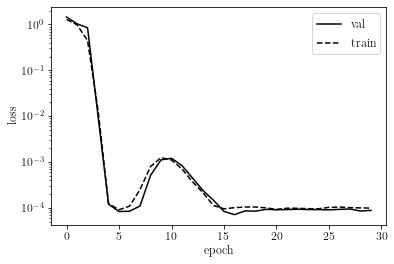

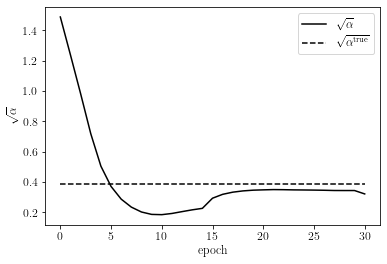

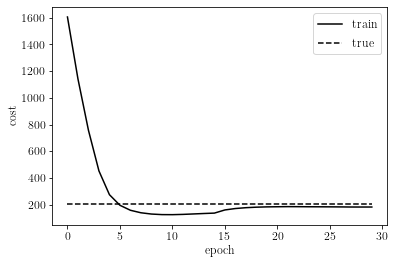

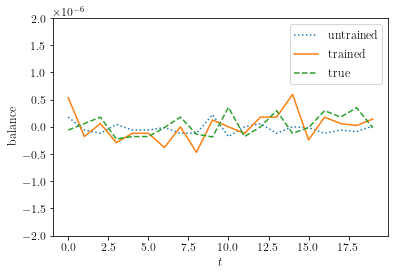

In [219]:
plot_results(val_losses_d, train_losses_d, param_updates_d, obj_vals_d, sqrtalpha_true, beta_true, P_untrained_d, P_trained_d, Pval_d, 'd')

In [228]:
# results
print('final sqrt(alpha) estimate: ', param_updates_d[-1,:].detach().numpy()[0])
print('true sqrt(alpha): ', sqrtalpha_true.detach().numpy()[0])
print('final objval estimate: ', obj_vals_d[-1])
print('true objval: ', f_gen(Pval_nd[0,:,0], sqrtalpha_true, beta_true).value[0])

final sqrt(alpha) estimate:  0.32212946
true sqrt(alpha):  0.38681477
final objval estimate:  181.39550418176665
true objval:  202.40317754321705
